# Local Outlier Factor (LOF) Detection of Anomalies

This is a nearest neighbor method.   The idea is to computer a local density near each observation/specimen,  based on how far the k nearest neighbors are.

Outliers will not have many close neighbors,  and thus a low density of points near them, so this can be detected.

Note that very high dimensional systmes (with many variables tend to have low densities, because of how much "space" is available among the many variables.
     
One could think of using a PCA first to reduce the dimensionality of the space and make it easier to detect outliers

See

https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py


In [1]:
# Outlier Detection with LOF

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]                                        #I think this is a row-bind operation

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1



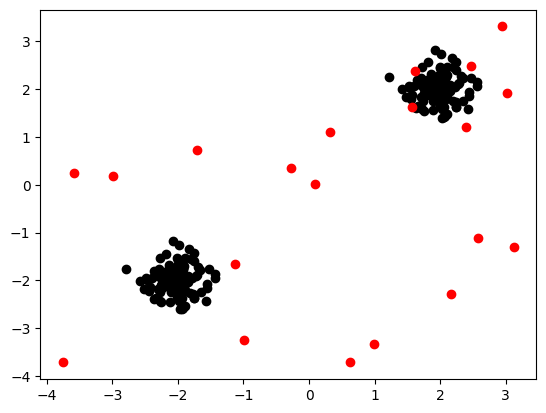

In [3]:
plt.scatter(X_inliers[:,0],X_inliers[:,1],color='k')
plt.scatter(X_outliers[:,0],X_outliers[:,1],color='r')

LOF is more limited in it's functions than the typical scikit learn predictor or transformer

It does not have predict(), decision_function() or score_samples() functions

In [4]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [5]:
print(n_errors)

8


Question/Action

Can you find out the mixture of false positives and false negatives?

Could you use a confusion matrix on this set of results?



- 17 TN
- 3 FP
- 5 FN
- 195 TP

In [8]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ground_truth, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 17   3]
 [  5 195]]


<ipython-input-9-24dcad02e99a>:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [10]
<ipython-input-9-24dcad02e99a>:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [20]


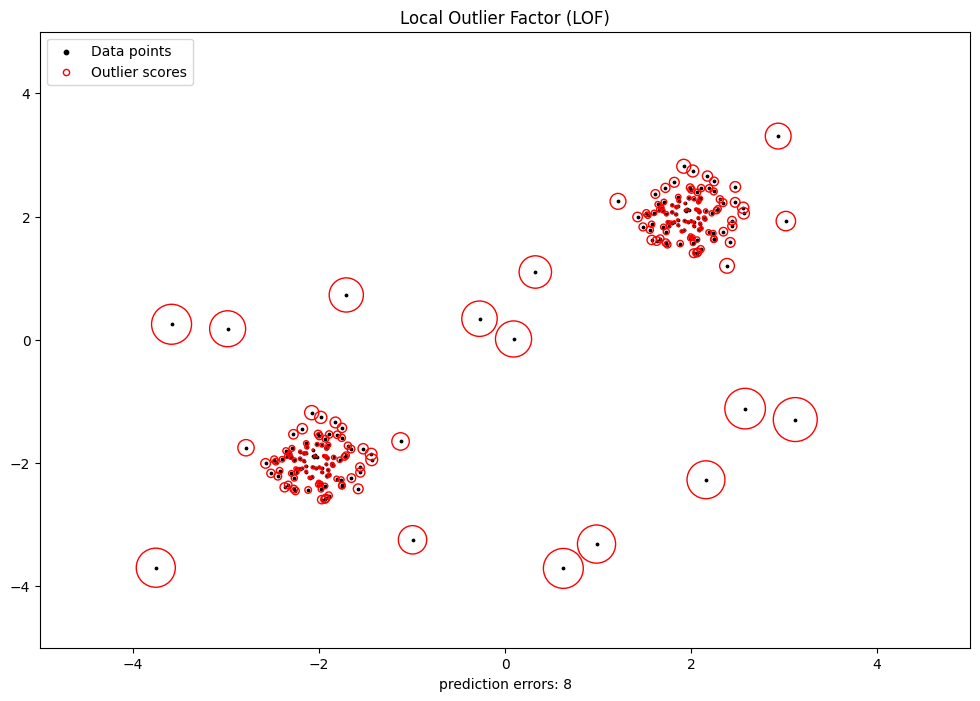

In [9]:
plt.figure(figsize=(12,8))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

Question/Action

What types of hyperparameters are there in the LocalOutlierFactor method?

Can you do some form of hyperparameter search,  either with your own loop system, or with the hyperparameter gridsearch to optimize
the performance of the LOF in this case?

class sklearn.neighbors.LocalOutlierFactor(n_neighbors=20, *, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination='auto', novelty=False, n_jobs=None)

In [35]:
from sklearn.metrics import f1_score

best_score = 0

for n_neighbors in [5, 10, 15, 20, 40, 60, 80, 100]:
  for contamination in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    clf2 = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = clf2.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()
    X_scores = clf2.negative_outlier_factor_

    f1 = f1_score(ground_truth, y_pred, average='weighted')

    if f1 > best_score:
      best_score = f1
      best_params = (n_neighbors, contamination)
      best_errors = n_errors

print('Error Amount:', best_errors)
print('f1:', best_score)
print('Hyper Parameters:', best_params)

Error Amount: 8
f1: 0.9644107985816527
Hyper Parameters: (5, 0.1)


## Novelty detection with the LOF method

We need to set the novelty=True parameter in LocalOutlierFactor,   there is now no fit_predict() option

See

https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_novelty_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-novelty-detection-py

In [36]:

np.random.seed(42)

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

# Generate normal (not abnormal) training observations
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]

# Generate new normal (not abnormal) observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]

# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

In [37]:
# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)

# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid

y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

n_error_test = y_pred_test[y_pred_test == -1].size

n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [38]:
print(n_error_test)
print()
print(n_error_outliers)

8

0


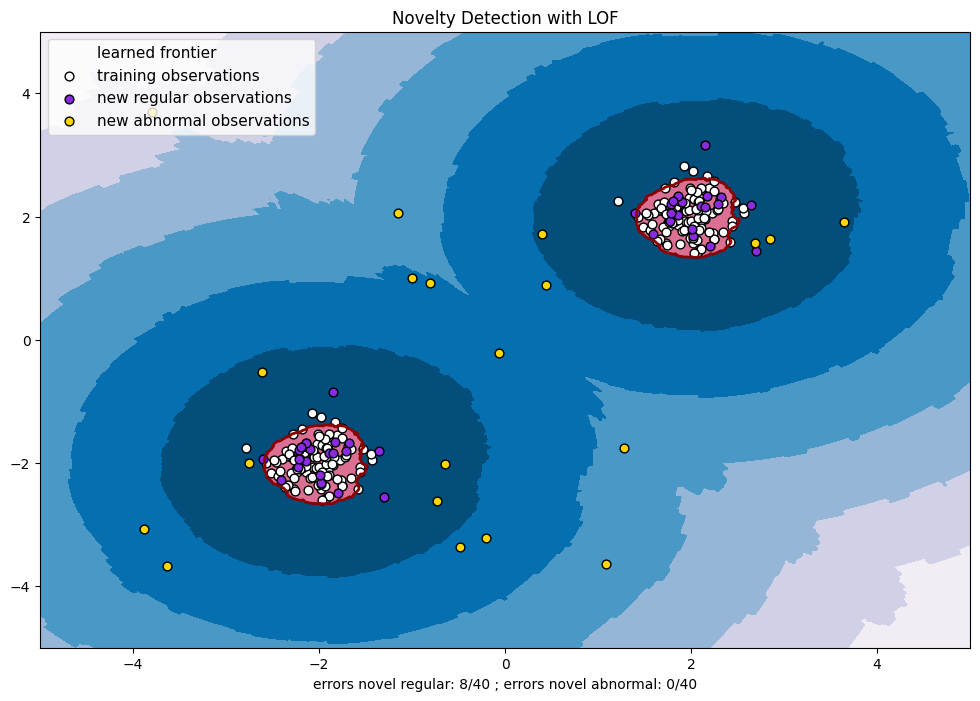

In [39]:
import matplotlib
# plot the learned frontier, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12,8))
plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [a.collections[0], b1, b2, c],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.xlabel(
    "errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_test, n_error_outliers)
)
plt.show()

## Other methods of Outlier Detection

- Robust Covariance Estimaters- draws ellipse around the mean data values at the estimated distances of the the "normal" data,  based on robust esimation of the
covariance structure in the data.   This is somewhat akin to using PCA.  SciKit learn has a function for it,  it seems unlikely to be a lot better than PCA

-Methods based on SVM- SVM means Support Vector Machine,  another form of classification predictor.  We will look at anomaly detection with SVMs after we cover SVMs

-Neural nets-  Using autoencoders- we'll look at that shortly